# Mine the Volleyball experiment either using spherical or heapix geometry

In [1]:
#%matplotlib
%load_ext autoreload
%autoreload 2

In [2]:
import copy as copy
import numpy as np
import pylab
import astropy
from astropy import constants as SI
import healpy as hp
# DISPATCH specific modules
#import _volleyball as vball
import _sphere_points as sp
import _patch as pt
#import _patch as patch
import vball_geometry as vg
import dispatch
import dispatch.select as ds2
import dispatch.graphics as dg;
import dispatch.EOS as EOS
import dispatch.solar_models
# I/O, OS, multiprocessing
import os
import pickle
import save_restore as sr
import multiprocessing as mp
# quick plots
from cmcrameri import cm
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
# VTK
import vtk
import pyevtk

ModuleNotFoundError: No module named 'healpy'

In [ ]:
def cd():
    os.chdir(workdir)

## Set experiment and snapshot

In [ ]:
disp = 'dispatch2'
experiment = 'volleyball'
home = os.path.expanduser('~')
top = os.path.join(home, 'codes/'+disp)
data=top+'/experiments/'+experiment+'/data/'
data='/mn/stornext/u3/andriusp/hpc_data/runs/'#+experiment#+'/new_runs'
run = 'small-mhd-655-995'
#run='small2'
run='VB96e'
iout = 200
workdir=top+'/experiments/'+experiment+'/python'
mineloc='analysis/mined_data'

In [ ]:
data

'/mn/stornext/u3/andriusp/hpc_data/runs/volleyball'

### Load the data

In [ ]:
snap = dispatch.snapshot(iout, run=run, data=data, verbose=0)


timer:
          patch metadata:  13.747 sec
             sorted-keys:   0.207 sec
attrib-from-snapshot_nml:   5.405 sec
            add-idx-attr:   7.372 sec
          llc-urc-extent:   5.986 sec
                    _var: 108.378 sec
                 letters:   2.022 sec
                 numbers:   1.185 sec
                   known:   0.576 sec
                read-aux:   1.398 sec
              all-values:   1.465 sec
             snapshot(1):   0.612 sec
            _add_axes(1):  13.144 sec
            _add_axes(2):   5.113 sec
          append+verbose:   0.708 sec


In [ ]:
pwd()

'/mn/stornext/d20/RoCS/andriusp/data/codes/dispatch2/experiments/volleyball/python'

### Load the volleyball mapping
we choose to load both healpix and spherical - different analysis benefit from different maps. Double check, that the mapped geometry is suitable for the particular simulation.

In [ ]:
# Use the following to load mapping from file
geom_file='VB96_vb_geom_r120_theta_50_phi_100.save'
sph_geom=vg.load_geometry(geom_file)
geom_file='VB96_vb_geom_r120_nside24.save'
hpix_geom = vg.load_geometry(geom_file)

In [ ]:
hpix_geom.run

'VB96f'

In [ ]:
np.matmul([bx[12,12,12],by[12,12,12],bz[12,12,12]],e)

array([-6.59986302e-10,  5.20665741e-09,  1.00000003e+00])

### Now we can mine the data.
The mined data is automatically saved in a pickle, so it can later be quickly reloaded and reused.

In [ ]:
# the following quantities are mined for healpix geometry
hpix_qty=['sph_vel','d','S','sph_mom']
hpix_qty=['S']
hpix_dataset={}
hpix_geom.mine_and_save(snap, loc=mineloc, dataset=hpix_dataset, run=run, quantity_list=hpix_qty, fresh=True, save=False)

mining S


In [ ]:
# the following quantities are mined for sherical geometry
sph_qty=['S']
sph_dataset={}
sph_geom.mine_and_save(snap, loc=mineloc, dataset=sph_dataset, run=run, quantity_list=sph_qty, fresh=True, save=False)

In [ ]:
qty_add=['uz','pz']
hpix_geom.mine_and_save(snap, loc=mineloc, dataset=dataset, run=run, quantity_list=qty_add, fresh=False, save=False)

mining uz
mining pz


In [ ]:
hpix_geom.dump_dataset(snap=snap,loc=mineloc,run=run,geometry=hpix_geom,dataset=dataset,overwrite=True)
sph_geom.dump_dataset(snap=snap,loc=mineloc,run=run,geometry=sph_geom,dataset=dataset,overwrite=True)

dataset saved in  analysis/mined_data/VB96e/r120nside24/340
dataset saved in  analysis/mined_data/VB96e/r120t50p100/340


In [ ]:
geom.sphere[52,318]

{'id': 152386,
 'pt_sph': array([-129.37950453, -129.37950453, -528.585457  ]),
 'pt_loc': array([269.43979895,   1.0628774 , -46.01247557]),
 'cell': array([27, 16, -8]),
 'wgt': array([ 0.16595607,  0.04700497, -0.1801094 ])}

In [ ]:
(snap.patches[0].li+snap.patches[0].ui-2)/2

array([14.5, 14.5, 14.5])

## We should convert the data to CGS or SI units

In [ ]:
dataset=hpix_dataset
# create a dictionary with scaling factors
scaling = { #'B_field_glob': snap.scaling.b, \
            #'B_field_loc' : snap.scaling.b, \
                     #  'd': snap.scaling.d, \
                       'S': snap.scaling.sm, \
                # 'sph_vel': snap.scaling.v, \
                # 'sph_mom': snap.scaling.v * snap.scaling.d#, \
            #         'uz' : snap.scaling.v, \
            #         'ux' : snap.scaling.v, \
            #         'uy' : snap.scaling.v
                    }

# alternatively, you can use the update() method
dataset.update((key, dataset[key] * value) for key, value in scaling.items())


In [ ]:
# create a dictionary with scaling factors
scaling = {
                 'uz': snap.scaling.v
                 'pz': snap.scaling.v * snap.scaling.d
                    }

# alternatively, you can use the update() method
dataset.update((key, dataset[key] * value) for key, value in scaling.items())

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1076237837.py, line 3)

In [ ]:
dataset['sph_vel']=dataset['sph_vel']*1e5
#dataset['sph_vel']=dataset['sph_vel']/1e5

### Quick-look at the dataset with hammer or other projections

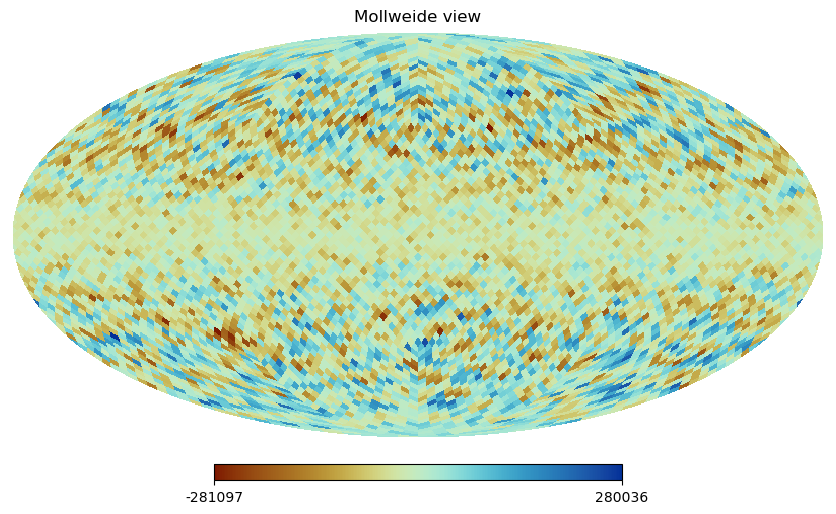

In [ ]:
hp.mollview(dataset['sph_vel'][-1,:,1],cmap=cm.roma)

/tmp/ipykernel_2848490/1097653864.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(x, y, dat, cmap=cm.roma)


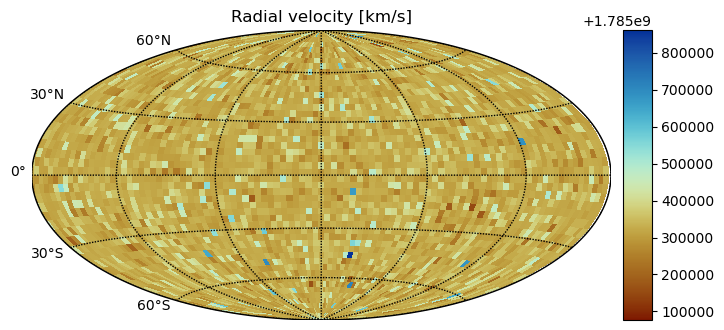

In [ ]:
geom_loc=sph_geom
data_loc=sph_dataset
phi   = np.unwrap(geom_loc.Phi)*180/np.pi
theta = geom_loc.Theta *180/np.pi
var='uz'
z=-4
#dat = np.log(np.sqrt(data_loc['sph_vel'][z, :, :,0]**2+data_loc['sph_vel'][z, :, :,1]**2+data_loc['sph_vel'][z, :, :,2]**2))
dat = data_loc['S'][z, :, :]
#dat = data_loc['uy'][z, :, :]**2+data_loc['ux'][z, :, :]**2#+data_loc['uz'][z, :, :]**2
#dat=S_nor[z,:,:]

# Set up the basemap
m = Basemap(projection='hammer', lon_0=0, lat_0=0, resolution='c')

# Convert the spherical coordinates to the Hammer projection
x, y = np.meshgrid(phi, theta)
x,y,=m(x,y)

# Plot the data on the Hammer projection
pl.figure(figsize=(8, 4))
m.pcolormesh(x, y, dat, cmap=cm.roma)
m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1])
m.colorbar()
pl.title(r'Radial velocity [km/s]')
pl.show()

In [ ]:
z=-1
print (dataset['sph_vel'][z,:,:,0].min(),dataset['sph_vel'][z,:,:,0].max(),dataset['sph_vel'][z,:,:,0].mean())
print (dataset['sph_vel'][z,:,:,1].min(),dataset['sph_vel'][z,:,:,1].max(),dataset['sph_vel'][z,:,:,1].mean())
print (dataset['sph_vel'][z,:,:,2].min(),dataset['sph_vel'][z,:,:,2].max(),dataset['sph_vel'][z,:,:,2].mean())
print (dataset['B_field_glob'][z,:,:,0].min(),dataset['B_field_glob'][z,:,:,0].max(),dataset['B_field_glob'][z,:,:,0].mean())
print (dataset['B_field_glob'][z,:,:,1].min(),dataset['B_field_glob'][z,:,:,1].max(),dataset['B_field_glob'][z,:,:,1].mean())
print (dataset['B_field_glob'][z,:,:,2].min(),dataset['B_field_glob'][z,:,:,2].max(),dataset['B_field_glob'][z,:,:,2].mean())

-803030.6501656085 833471.5594471833 3108.347774370004
-808787.7329663594 1078339.97066689 718.7059922636181
-730047.9618225945 881405.7503841093 4780.093162197394


KeyError: 'B_field_glob'

In [ ]:
omeg=np.zeros((sph_geom.nR,sph_geom.nTheta))
for i, r in enumerate(sph_geom.R):
    for j, t in enumerate(sph_geom.Theta):
        omeg[i,j]=sph_dataset['sph_vel'][i,j,:,2].mean()/(r*np.cos(t)*2.0*np.pi*1e8)*1e9+424

In [ ]:
R=sph_geom.R/SI.R_sun.cgs.value*1e8

In [ ]:
sph_geom.Theta*180/np.pi

array([-90.        , -86.32653061, -82.65306122, -78.97959184,
       -75.30612245, -71.63265306, -67.95918367, -64.28571429,
       -60.6122449 , -56.93877551, -53.26530612, -49.59183673,
       -45.91836735, -42.24489796, -38.57142857, -34.89795918,
       -31.2244898 , -27.55102041, -23.87755102, -20.20408163,
       -16.53061224, -12.85714286,  -9.18367347,  -5.51020408,
        -1.83673469,   1.83673469,   5.51020408,   9.18367347,
        12.85714286,  16.53061224,  20.20408163,  23.87755102,
        27.55102041,  31.2244898 ,  34.89795918,  38.57142857,
        42.24489796,  45.91836735,  49.59183673,  53.26530612,
        56.93877551,  60.6122449 ,  64.28571429,  67.95918367,
        71.63265306,  75.30612245,  78.97959184,  82.65306122,
        86.32653061,  90.        ])

2
17
31
50
64
79


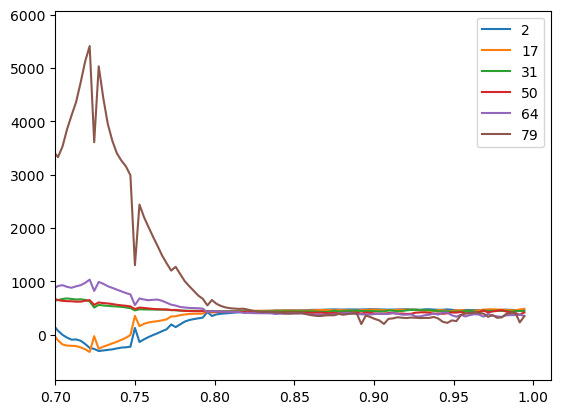

In [ ]:
for i in (25,29,33,38,42,46):
    print (round(sph_geom.Theta[i]*180/np.pi))
    pl.plot(R,omeg[:,i],label=f'{round(sph_geom.Theta[i]*180/np.pi)}')
pl.xlim(0.7,None)
#pl.ylim(250,520)
pl.legend()

2
17
31
50
64
79


(-130.0, 50.0)

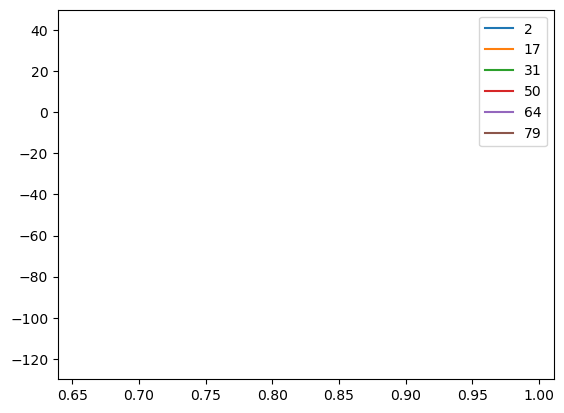

In [ ]:
for i in (25,29,33,38,42,46):
    print (round(sph_geom.Theta[i]*180/np.pi))
    pl.plot(R,om_hmi[:,i],label=f'{round(sph_geom.Theta[i]*180/np.pi)}')
pl.legend()
pl.ylim(-130,50)

In [ ]:
dataset['sph_vel'][-4,0,:,0]

array([ 12591.16294168,  13310.26904691,  13976.84560109,  14588.26193109,
        15142.105056  ,  15636.18921002,  16068.56446872,  16437.5244445 ,
        16741.61302088,  16979.63009918,  17150.63633474,  17253.95684407,
        17289.18386831,  17256.17838251,  17155.07064422,  16986.25967951,
        16750.41170813,  16448.45751427,  16081.58877319,  15651.2533482 ,
        15159.14957662,  14607.21956722,  13997.64153559,  13332.82120774,
        12615.38232576,  11848.15629317,  11034.17100059,  10176.63887611,
         9278.94420724,   8344.62978474,   7377.38292078,   6381.02089683,
         5359.47589861,   4316.77949754,   3257.04673993,   2184.45990685,
         1103.2520085 ,     17.6900785 ,  -1067.94166616,  -2149.35873296,
        -3222.29326278,  -4282.51087323,  -5325.82736975,  -6348.12525878,
        -7345.3699976 ,  -8313.62591682,  -9249.07175268, -10148.01572783,
       -11006.91012109, -11822.36526868, -12591.16294168, -13310.26904691,
       -13976.84560109, -

In [ ]:
rot = np.genfromtxt('rot2d.hmiv72d.ave')
rad = np.genfromtxt('rmesh.orig')
err = np.genfromtxt('err2d.hmiv72d.ave')
r = rad[::4]
i = np.arange(rot.shape[1])
lat = (90-i*15/8)*np.pi/180.
lat=lat[::-1]
rot=rot[:,::-1]
Nr = len(r)
Nlat = len(lat)

In [ ]:
om_hmi=np.zeros((len(R),sph_geom.nTheta))
for i,rr in enumerate(R):
    for j, th in enumerate(sph_geom.Theta):
        om_hmi[i,j]=bilinear(r,lat,rr,abs(th),rot)

In [ ]:
abs(geom.Theta)

array([1.57079633e+00, 1.50796447e+00, 1.44513262e+00, 1.38230077e+00,
       1.31946891e+00, 1.25663706e+00, 1.19380521e+00, 1.13097336e+00,
       1.06814150e+00, 1.00530965e+00, 9.42477796e-01, 8.79645943e-01,
       8.16814090e-01, 7.53982237e-01, 6.91150384e-01, 6.28318531e-01,
       5.65486678e-01, 5.02654825e-01, 4.39822972e-01, 3.76991118e-01,
       3.14159265e-01, 2.51327412e-01, 1.88495559e-01, 1.25663706e-01,
       6.28318531e-02, 2.22044605e-16, 6.28318531e-02, 1.25663706e-01,
       1.88495559e-01, 2.51327412e-01, 3.14159265e-01, 3.76991118e-01,
       4.39822972e-01, 5.02654825e-01, 5.65486678e-01, 6.28318531e-01,
       6.91150384e-01, 7.53982237e-01, 8.16814090e-01, 8.79645943e-01,
       9.42477796e-01, 1.00530965e+00, 1.06814150e+00, 1.13097336e+00,
       1.19380521e+00, 1.25663706e+00, 1.31946891e+00, 1.38230077e+00,
       1.44513262e+00, 1.50796447e+00])

In [ ]:
def bilinear(x,y,xi,yi,f):
  n = len(x)-1   # Number of grid points in x direction
  m = len(y)-1   # Number of grid points in y direction

  xl=max(min(xi,x[n]),x[0])
  yl=max(min(yi,y[m]),y[0])


  # Find the closest valid indices for xi and yi
  for i1 in range (1, n):
    if (xl<x[i1]):
      i=i1-1
      break
    else:
      i=i1
  if (i==n):
     i=i-1

  for j1 in range(1, m):
    if (yl<y[j1]):
      j=j1-1
      break
    else:
      j=j1
  if (j==m):
     j=j-1


  # Compute the interpolation weights
  dx = (xl - x[i]) / (x[i+1] - x[i])
  dy = (yl - y[j]) / (y[j+1] - y[j])
  tx = 1.0 - dx
  ty = 1.0 - dy

  # Perform the bilinear interpolation
  return tx * ty * f[i, j  ] + dx * ty * f[i+1, j  ] + \
           tx * dy * f[i, j+1] + dx * dy * f[i+1, j+1]

In [ ]:
om_hmi[0,:]

array([481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344,
       481.8957344, 481.8957344, 481.8957344, 481.8957344, 481.8957344])

## Read in the EOS table.
Note, that we want to use the same table as in the experiment.

In [ ]:
def lookup(name,d,S):
    return eosS.lookup(name, np.log(d), S)
def inverse_lookup(name,d,v):
    if np.iterable(d):
        n=len(d)
        out=np.zeros(n)
        for i in range(len(d)):
            out[i]=eosS.inverse_lookup(name,np.log(d[i]),v[i])
    else:
        out = eosS.inverse_lookup(name, np.log(d), v)
    return out

../../../data/eos/Free-S.eos
ln(rho)  min: -2.303e+01   step:  1.151e-02   max:  5.066e+00
S        min:  1.000e+09   step:  5.001e+05   max:  3.000e+09
variables: {0: 'ln(P)', 1: 'ln(kr)', 2: 'ee', 3: 'ln(ne)', 4: 'ln(kp)', 5: 'ln(k500)', 6: 'T', 7: 'gamma'}
scale0: ln(rho)
scale1: S
type: Free_EOS-S
file: ../../../data/eos/Free-S.eos


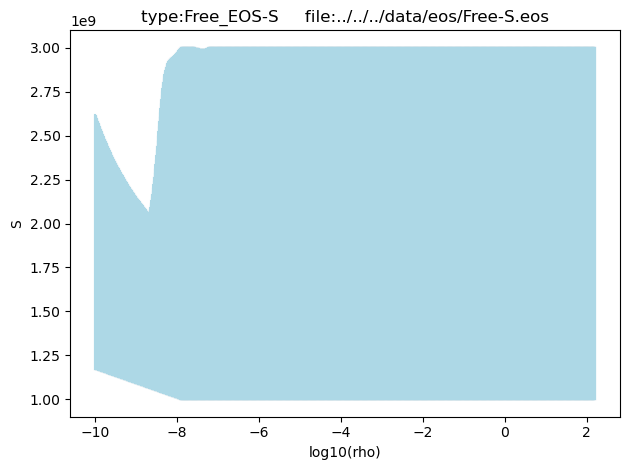

In [ ]:
eos_tab_name='../'+snap.eos.dir.strip()+snap.eos.file.strip()+'.'+snap.eos.file_ext.strip()
print(eos_tab_name)
eosS=EOS.read(eos_tab_name,verbose=1)


#### Add additional quantities to the dataset

In [ ]:
#Spherical
dat=dataset
geo=geom
#pg=np.zeros((geo.nR,geo.nTheta,geo.nPhi))
#tg=np.zeros((geo.nR,geo.nTheta,geo.nPhi))
#ee=np.zeros((geo.nR,geo.nTheta,geo.nPhi))
#for i in range(geo.nR):
#    for j in range(geo.nTheta):
#        for k in range(geo.nPhi):
#            pg[i,j,k]= lookup('P',dat['d'][i,j,k],dat['S'][i,j,k])
#            tg[i,j,k]= lookup('T',dat['d'][i,j,k],dat['S'][i,j,k])
#            ee[i,j,k]= lookup('ee',dat['d'][i,j,k],dat['S'][i,j,k])
#dat['E']=ee
#dat['T']=tg
#dat['Pg']=pg
dat['Pg']= lookup('P',dat['d'],dat['S'])
dat['T']= lookup('T',dat['d'],dat['S'])
dat['ee']= lookup('ee',dat['d'],dat['S'])

AttributeError: 'Mapped_Healpix' object has no attribute 'nTheta'

In [ ]:
#Hpix
dat=hpix_dataset
geo=hpix_geom
pg=np.zeros((geo.nR,geo.npix))
tg=np.zeros((geo.nR,geo.npix))
ee=np.zeros((geo.nR,geo.npix))
for i in range(geo.nR):
    for j in range(geo.npix):
        pg[i,j]= np.exp(lookup('ln(P)',dat['d'][i,j],dat['S'][i,j]))
        tg[i,j]= lookup('T',dat['d'][i,j],dat['S'][i,j])
        ee[i,j]= lookup('ee',dat['d'][i,j],dat['S'][i,j])
dat['Pg']=pg
dat['T']=tg
dat['ee']=ee
#dat['Pg']= lookup('P',dat['d'],dat['S'])
#dat['T']= lookup('T',dat['d'],dat['S'])
#dat['ee']= lookup('ee',dat['d'],dat['S'])

### Read in the default Model-S and the one we used.

In [ ]:
from scipy.io import FortranFile
#
geom=hpix_geom
model_S=dispatch.solar_models.JCD_S(top=top)
mod_S_ref={}
mod_S_ref['r']=model_S.r
mod_S_ref['T']=model_S.T
mod_S_ref['d']=model_S.rho
mod_S_ref['Pg']=model_S.P
mask = (mod_S_ref['r'] >= geom.R.min()/ snap.cgs.r_sun*snap.scaling.l) & \
       (mod_S_ref['r'] <= geom.R.max()/ snap.cgs.r_sun*snap.scaling.l)
mod_S_ref['r'] = mod_S_ref['r'][mask]
mod_S_ref['Pg'] = mod_S_ref['Pg'][mask]
mod_S_ref['T'] = mod_S_ref['T'][mask]
mod_S_ref['d'] = mod_S_ref['d'][mask]
mod_S_ref['S']=inverse_lookup('T',mod_S_ref['d'],mod_S_ref['T'])
mod_S_ref['E']=lookup('ee',mod_S_ref['d'],mod_S_ref['S'])
#
#cd()
mod_S_dir=top+'/data/solar_models/JCD-model-S-Free.dat'
print (mod_S_dir)
mod_S={}
with FortranFile(mod_S_dir, 'r') as fd:
    # Read the first record to get n and len(idx)
    n, idx_len = fd.read_record('<i4,<i4')[0]
    # Initialize empty arrays to hold the data
    r, g, d, E, T, S = [], [], [], [], [], []
    # Read each subsequent record and append the data to the arrays
    for i in range(n):
        record = fd.read_record('<f8,<f8,<f8,<f8,<f8,<f8')[0]
        r.append(record[0])
        g.append(record[1])
        d.append(record[2])
        E.append(record[3])
        T.append(record[4])
        S.append(record[5])
mod_S['r']=np.array(r)
mod_S['g']=np.array(g)
mod_S['d']=np.array(d)
mod_S['E']=np.array(E)
mod_S['T']=np.array(T)
mod_S['S']=np.array(S)
mask = (mod_S['r'] >= geom.R.min()/ snap.cgs.r_sun*snap.scaling.l) & \
       (mod_S['r'] <= geom.R.max()/ snap.cgs.r_sun*snap.scaling.l)
mod_S['r'] = mod_S['r'][mask]
mod_S['g'] = mod_S['g'][mask]
mod_S['d'] = mod_S['d'][mask]
mod_S['E'] = mod_S['E'][mask]
mod_S['T'] = mod_S['T'][mask]
mod_S['S'] = mod_S['S'][mask]
mod_S['Pg']=np.exp(lookup('ln(P)',mod_S['d'],mod_S['S']))

/mn/stornext/u3/andriusp/codes/dispatch2/data/solar_models/JCD-model-S-Free.dat


In [ ]:
snap.patches[0].keys

{'letters': ['d',
  'e',
  'et',
  's',
  'px',
  'py',
  'pz',
  'bx',
  'by',
  'bz',
  'qr',
  'tt',
  'phi',
  'p1',
  'p2',
  'p3',
  'b1',
  'b2',
  'b3',
  'ex',
  'ey',
  'ez',
  'jx',
  'jy',
  'jz',
  'rphi'],
 'numbers': [0,
  -2,
  -1,
  4,
  1,
  2,
  3,
  5,
  6,
  7,
  -1,
  -1,
  -1,
  1,
  2,
  3,
  5,
  6,
  7,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1],
 'known': ['d',
  'lnd',
  'logd',
  'ux',
  'uy',
  'uz',
  'u1',
  'u2',
  'u3',
  'wx',
  'wy',
  'wz',
  'w2',
  'divu',
  'Jeans',
  'L_J',
  'ee',
  'E',
  'T',
  'eth',
  'Eth',
  'ekin',
  'emag',
  'e_tot',
  's',
  'S',
  'P',
  'pg',
  'pgas',
  'Bx',
  'By',
  'Bz']}

In [ ]:
mod_S['r']

array([0.48079033, 0.48083601, 0.48088169, ..., 1.00060432, 1.00065853,
       1.0007126 ])

In [ ]:
12*(64*64)

49152

In [ ]:
mod_S_dir='../'+snap.model_1d.dir.strip()+snap.model_1d.file
print (mod_S_dir)
for line in f:
    line = line.strip()
    col = line.split()
    if ir == 0:
        ots[it] = float(col[1])
    if it == 0:
        ors[ir] = float(col[0])
    od[ir, it, i] = float(col[2])+ors[ir]
    ir += 1
    if ir > onr-1:
        it += 1
        ir = 0
f.close()


../../../data/solar_models/JCD-model-S.dat                                                 


NameError: name 'f' is not defined

# Now we can process the snapshot, extract anything we want

### RMS velocity

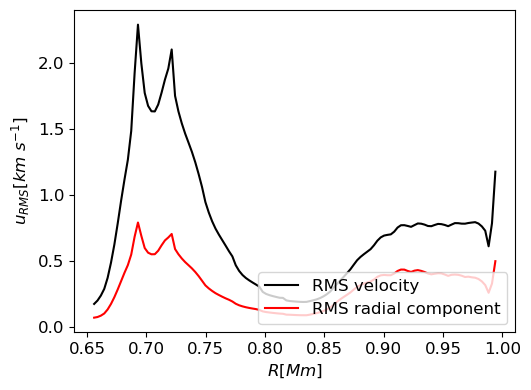

In [ ]:
geom_loc=hpix_geom
data_loc=dataset
#
pl.figure(figsize=(10, 4))
u_rms=np.zeros(geom_loc.nR)
u_zz=np.zeros(geom_loc.nR)
u_min=np.zeros(geom_loc.nR)
u_max=np.zeros(geom_loc.nR)
for z in range(geom_loc.nR):
    rms_r= np.sqrt(data_loc['sph_vel'][z,:,0]**2+data_loc['sph_vel'][z,:,1]**2+data_loc['sph_vel'][z,:,2]**2)
    rms_z= np.sqrt(data_loc['sph_vel'][z,:,0]**2)
    #rms_r= np.sqrt(data_loc['ux'][z,:,:]**2+data_loc['uy'][z,:,:]**2+data_loc['uz'][z,:,:]**2)
    #mask = (data_loc['sph_vel'][z,:,:,0] >= 0)
    #u_rms[z] = rms_r[mask].mean()
    rms_r=rms_r/1e5
    rms_z=rms_z/1e5
    u_rms[z] = rms_r.mean()
    u_zz[z] = rms_z.mean()
    u_min[z] = rms_r.min()
    u_max[z] = rms_r.max()
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
pl.plot(Rs, u_rms, c='black', label='RMS velocity')
pl.plot(Rs, u_zz, c='red', label='RMS radial component')
#pl.fill_between(Rs, u_min, u_max, alpha=0.3, color='gray')
#pl.scatter(a3[0][r1:r2], a3[1][r1:r2], s=4, c='blue', label='HLLS, n=500')
pl.xlabel(r'$R [Mm]$', fontsize=fontsize)
pl.ylabel(r'$u_{RMS} [km ~s^{-1}]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
pl.legend(fontsize=fontsize, loc='lower right')
pl.tight_layout()

### Radial profiles

In [ ]:
geom_loc=geom
data_loc=dataset
#
var='d'
pl.figure(figsize=(14, 4))
a=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)
for z in range(geom_loc.nR):
    a[z]= data_loc[var][z,:].mean()
    a_min[z]= data_loc[var][z,:].min()
    a_max[z]= data_loc[var][z,:].max()
a_range=a_max-a_min
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
pl.plot(mod_S_ref['r'], mod_S_ref['d'], c='red', alpha=0.8, label=r'Model-S')
pl.plot(mod_S['r'], mod_S['d'], c='blue', alpha=0.8, label=r'modified Model-S')
pl.plot(Rs, a, c='black', label=r'Simulation')
pl.fill_between(Rs, a_min, a_max, alpha=0.3, color='gray')
#pl.scatter(a3[0][r1:r2], a3[1][r1:r2], s=4, c='blue', label='HLLS, n=500')
pl.xlabel(r'$R [Mm]$', fontsize=fontsize)
pl.ylabel(r'$\rho ~ [g ~cm^{-3}]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
pl.legend(fontsize=fontsize, loc='lower left')
pl.tight_layout()

NameError: name 'geom' is not defined

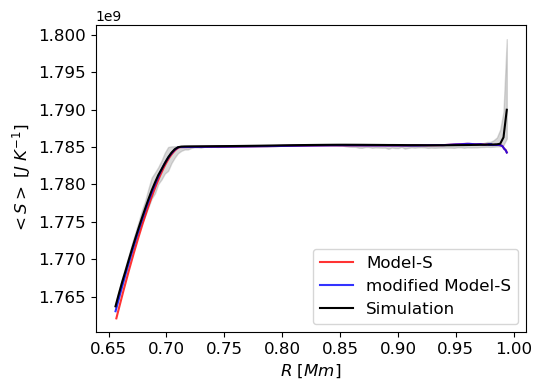

In [ ]:
geom_loc=geom
data_loc=dataset
#
var='S'
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)
for z in range(geom_loc.nR):
    a[z]= data_loc[var][z,:].mean()
    a_min[z]= data_loc[var][z,:].min()
    a_max[z]= data_loc[var][z,:].max()
a_range=a_max-a_min
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
pl.plot(mod_S_ref['r'], mod_S_ref['S'], c='red', alpha=0.8, label=r'Model-S')
pl.plot(mod_S['r'], mod_S['S'], c='blue', alpha=0.8, label=r'modified Model-S')
pl.plot(Rs, a, c='black', label='Simulation')
pl.fill_between(Rs, a_min, a_max, alpha=0.3, color='gray')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$<S> ~[J ~K^{-1}]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
pl.legend(fontsize=fontsize, loc='lower right')
pl.tight_layout()

NameError: name 'mod_S_ref' is not defined

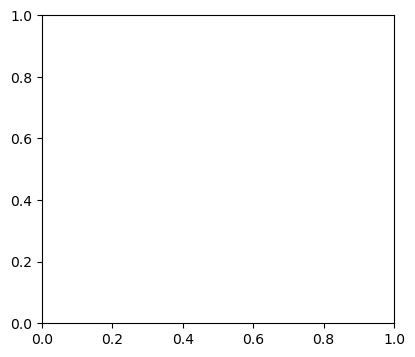

In [ ]:
geom_loc=hpix_geom
data_loc=hpix_dataset
#
var='T'
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)
for z in range(geom_loc.nR):
    a[z]= data_loc[var][z,:].mean()
    a_min[z]= data_loc[var][z,:].min()
    a_max[z]= data_loc[var][z,:].max()
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
pl.plot(mod_S_ref['r'], np.log(mod_S_ref[var]), c='red', alpha=0.8, label=r'Model-S')
pl.plot(mod_S['r'], np.log(mod_S[var]), c='blue', alpha=0.8, label=r'modified Model-S')
pl.plot(Rs, np.log(a), c='black', label='Simulation')
pl.fill_between(Rs, np.log(a_min), np.log(a_max), alpha=0.3, color='gray')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$<ln~T> ~[K]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
pl.legend(fontsize=fontsize, loc='lower left')
pl.tight_layout()

In [ ]:
(geom_loc.R[-1]*snap.scaling.l)**2 * 4 * np.pi*SI.sigma_sb.cgs.value*5770**4

3.779994617475076e+33

In [ ]:
SI.sigma_sb.cgs.value*31262**4/10**13

5.4160014461146355

In [ ]:
eosS.values()

TypeError: itable_c.values() missing 2 required positional arguments: 'ir' and 'iv'

In [ ]:
a

array([2769177.96189051, 2745359.85001661, 2722078.75936091,
       2701598.67371918, 2672897.35991502, 2652246.78414505,
       2627294.40381236, 2605725.8992682 , 2581255.85665363,
       2557966.70101545, 2534022.33758863, 2507496.5996423 ,
       2486079.53029432, 2461254.34048964, 2432372.2979214 ,
       2407471.61121744, 2382347.31677101, 2355587.56646462,
       2330562.15944988, 2298992.90713348, 2272014.43463412,
       2239142.38393189, 2206820.19720227, 2177140.73952365,
       2143317.73703459, 2113552.25831347, 2082646.37276677,
       2050370.29108633, 2022016.981888  , 1989591.92606138,
       1962186.644673  , 1934363.31261452, 1904813.6603477 ,
       1875485.93568613, 1843747.84794982, 1815883.81378299,
       1788918.47587979, 1760485.66746217, 1731826.17759217,
       1701666.84179346, 1675695.23307348, 1649054.11772487,
       1623160.67379572, 1595069.80464947, 1566908.70730303,
       1542295.44307573, 1516004.27932865, 1489729.28106949,
       1461120.73839791,

NameError: name 'mod_S_ref' is not defined

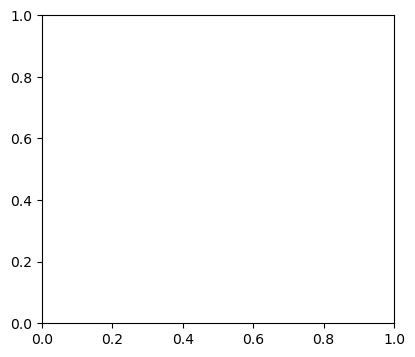

In [ ]:
geom_loc=hpix_geom
data_loc=hpix_dataset
#
var='Pg'
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)
for z in range(geom_loc.nR):
    a[z]= data_loc[var][z,:].mean()
    a_min[z]= data_loc[var][z,:].min()
    a_max[z]= data_loc[var][z,:].max()
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
pl.plot(mod_S_ref['r'], np.log(mod_S_ref[var]), c='red', alpha=0.8, label=r'Model-S')
pl.plot(mod_S['r'], np.log(mod_S[var]), c='blue', alpha=0.8, label=r'modified Model-S')
pl.plot(Rs, np.log(a), c='black', label='Simulation')
pl.fill_between(Rs, np.log(a_min), np.log(a_max), alpha=0.3, color='gray')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$<ln~Pg> [dyne ~cm^{-2}]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
pl.legend(fontsize=fontsize, loc='lower left')
pl.tight_layout()

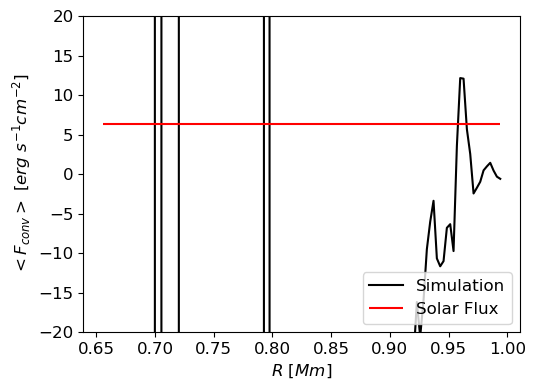

In [ ]:
geom_loc=geom
data_loc=dataset
#
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR)
am=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)

for z in range(geom_loc.nR):
    avg_mom = data_loc['sph_mom'][z,:,0]-data_loc['sph_mom'][z,:,0].mean()
    am[z]=avg_mom.mean()
    conv_fl=avg_mom*(data_loc['ee'][z,:]+data_loc['Pg'][z,:])/data_loc['d']
    a[z]= conv_fl.mean()
    a_min[z]= conv_fl.min()
    a_max[z]= conv_fl.max()
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
pl.plot(Rs, a/1e12, c='black', label='Simulation')
pl.hlines(y=6.325, xmin=Rs[0],xmax=Rs[-1] , color='red', label='Solar Flux')
#pl.fill_between(Rs, a_min, a_max, alpha=0.3, color='gray')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$<F_{conv}> ~[erg ~s^{-1} cm^{-2}]$', fontsize=fontsize)
pl.ylim([-2e1,2e1])
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
pl.legend(fontsize=fontsize, loc='lower right')
pl.tight_layout()

In [ ]:
am

array([ 0.00000000e+00, -8.42124724e-15,  3.36849890e-14,  3.36849890e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.02109934e-13,
       -2.02109934e-13, -2.69479912e-13, -2.02109934e-13,  0.00000000e+00,
        3.36849890e-14,  0.00000000e+00,  0.00000000e+00, -8.08439735e-13,
       -1.34739956e-13, -2.02109934e-13, -1.34739956e-13, -6.73699779e-14,
       -2.69479912e-13,  6.73699779e-14,  1.34739956e-13,  2.69479912e-13,
       -1.01054967e-13,  2.69479912e-13,  3.36849890e-13, -1.34739956e-13,
        0.00000000e+00,  5.38959823e-13, -4.04219867e-13,  0.00000000e+00,
       -2.69479912e-13,  0.00000000e+00, -1.34739956e-13, -1.34739956e-13,
       -1.34739956e-13,  0.00000000e+00,  1.34739956e-13,  0.00000000e+00,
        1.34739956e-13,  6.73699779e-14,  0.00000000e+00,  0.00000000e+00,
       -1.34739956e-13,  0.00000000e+00,  3.36849890e-14,  6.73699779e-14,
       -6.73699779e-14, -1.01054967e-13, -1.68424945e-14,  8.42124724e-14,
       -1.68424945e-13,  

In [ ]:
import scipy
dd1=scipy.interpolate.interp1d(mod_S_ref['r'], mod_S_ref['d'], kind='cubic', axis=-1, copy=True, bounds_error=None, fill_value=np.nan, assume_sorted=False)
drm=dd1(rrr[1:-1])
dd2=scipy.interpolate.interp1d(mod_S_ref['r'], mod_S_ref['E'], kind='cubic', axis=-1, copy=True, bounds_error=None, fill_value=np.nan, assume_sorted=False)
dre=dd2(rrr[1:-1])
dd3=scipy.interpolate.interp1d(mod_S_ref['r'], mod_S_ref['Pg'], kind='cubic', axis=-1, copy=True, bounds_error=None, fill_value=np.nan, assume_sorted=False)
drp=dd3(rrr[1:-1])

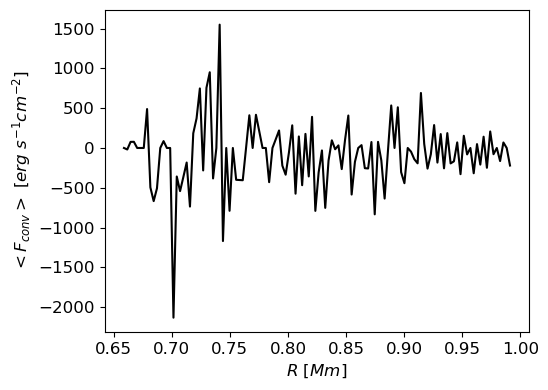

In [ ]:
geom_loc=geom
data_loc=dataset
#
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR-2)
a_min=np.zeros(geom_loc.nR-2)
a_max=np.zeros(geom_loc.nR-2)

for z in range(geom_loc.nR-3):
    zz=z+1
    avg_mom = data_loc['sph_mom'][zz,:,0]-data_loc['sph_mom'][zz,:,0].mean()
    conv_fl=avg_mom.mean()*(dre[zz]+drp[zz])/drm[zz]
    a[zz]= conv_fl.mean()
    a_min[zz]= conv_fl.min()
    a_max[zz]= conv_fl.max()
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R[1:-1] / snap.cgs.r_sun*snap.scaling.l
pl.plot(Rs, a, c='black', label='Simulation')
#pl.fill_between(Rs, a_min, a_max, alpha=0.3, color='gray')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$<F_{conv}> ~[erg ~s^{-1} cm^{-2}]$', fontsize=fontsize)
#pl.ylim([-1e14,1e14])
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
#pl.legend(fontsize=fontsize, loc='lower left')
pl.tight_layout()

In [ ]:
len(drm)

118

In [ ]:
#kinetic energy flux
geom_loc=geom
data_loc=dataset
#
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)
for z in range(geom_loc.nR):
    #conv_fl=((data_loc['sph_vel'][z,:,0]-data_loc['sph_vel'][z,:,0].mean())*(data_loc['d'][z,:]*data_loc['E'][z,:]+data_loc['Pg'][z,:]))
    conv_fl=((data_loc['pz'][z,:]-data_loc['pz'][z,:].mean())*(data_loc['d'][z,:]*data_loc['E'][z,:]+data_loc['Pg'][z,:]))
    a[z]= conv_fl.mean()
    a_min[z]= conv_fl.min()
    a_max[z]= conv_fl.max()
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
pl.plot(Rs, a, c='black', label='Simulation')
#pl.fill_between(Rs, a_min, a_max, alpha=0.3, color='gray')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$<F_{conv}> ~[erg ~s^{-1} cm^{-2}]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
#pl.legend(fontsize=fontsize, loc='lower left')
pl.tight_layout()

KeyError: 'E'

<Figure size 1000x400 with 0 Axes>

In [ ]:
data_loc['sph_vel']=data_loc['sph_vel']*1e5

In [ ]:
geom_loc=geom
data_loc=dataset
#
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)
conv_fl=((data_loc['sph_vel'][:,:,0]-data_loc['sph_vel'][:,:,0].mean((0)))*(data_loc['d']*data_loc['E']+data_loc['Pg']))
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
for i in range (geom_loc.npix):
    pl.plot(Rs, conv_fl[:,i], c='red', alpha=0.005, label='Simulation')
pl.plot(Rs, conv_fl.mean((1)), c='black', alpha=1, label='Simulation')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$<F_{conv}> ~[erg ~s^{-1} cm^{-2}]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
#pl.legend(fontsize=fontsize, loc='lower left')
pl.tight_layout()

KeyError: 'E'

<Figure size 1000x400 with 0 Axes>

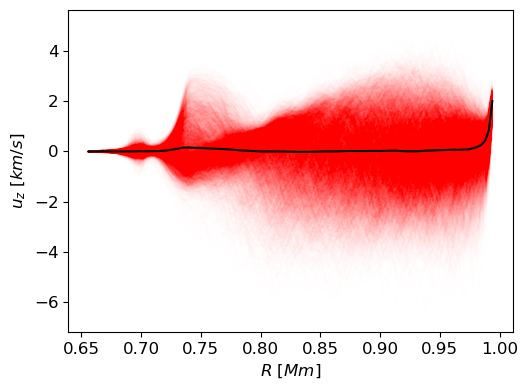

In [ ]:
geom_loc=geom
data_loc=dataset
#
pl.figure(figsize=(10, 4))
a=np.zeros(geom_loc.nR)
a_min=np.zeros(geom_loc.nR)
a_max=np.zeros(geom_loc.nR)
conv_fl=data_loc['uz'][:,:]
fontsize = 12
pl.subplot(1, 2, 1)
Rs = geom_loc.R / snap.cgs.r_sun*snap.scaling.l
for i in range (geom_loc.npix):
    pl.plot(Rs, conv_fl[:,i], c='red', alpha=0.005, label='Simulation')
pl.plot(Rs, conv_fl.mean((1)), c='black', alpha=1, label='Simulation')
pl.xlabel(r'$R ~[Mm]$', fontsize=fontsize)
pl.ylabel(r'$u_z ~[km / s]$', fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.xticks(fontsize=fontsize)
#pl.legend(fontsize=fontsize, loc='lower left')
pl.tight_layout()

In [ ]:
idx2r     = {idx: np.round(np.sqrt(np.sum(p.position**2))) for idx, p in enumerate(snap.patches) }
idx2theta = {idx: np.round(np.arcsin(p.position[2]/np.sqrt(np.sum(p.position**2)))) for idx, p in enumerate(snap.patches) }
idx2phi   = {idx: np.round(np.arctan2( p.position[1], p.position[0])) for idx, p in enumerate(snap.patches) }
uniqueR = set(idx2r.values())
uniquePhi = set(idx2phi.values())
uniqueTheta = set(idx2theta.values())
minR = 0.699 * snap.cgs.r_sun/snap.scaling.l
maxR = 0.995 * snap.cgs.r_sun/snap.scaling.l
nR    = 120
R     = np.linspace(minR,maxR,nR)
nside=32
npix = 12*nside**2
th=np.zeros(npix)
ph=np.zeros(npix)
for i in range(npix):
    theta, phi = hp.pix2ang(nside, i)
    th[i]=theta
    ph[i]=phi
hTheta = th
Theta  = th - np.pi/2
hPhi   = ph
Phi    = ph - np.pi

In [ ]:
missing=[10,3159,3177,3223,3241]
mTheta=Theta[missing]
mPhi  =Phi  [missing]
mR=R[-1]
spp=sp.point_on_sphere(0.5)
dr=np.max(abs(np.diff(np.sort(list(uniqueR)))))
dphi=np.pi/2
dtheta=np.pi/4

In [ ]:
ii=2
theta=mTheta[ii]
phi=mPhi[ii]
ids1 = [pid for pid, tr   in idx2r.items() if abs(tr-mR) <= dr]
ids2 = [pid for pid, tphi in idx2phi.items() if abs(((tphi-phi)+np.pi)%(2*np.pi)-np.pi) <= dphi]
ids3 = [pid for pid, tst  in idx2theta.items() if abs(tst-theta)  <= dtheta]
ids  = set.intersection(set(ids1),set(ids2), set(ids3))
point = np.array(spp.cartesian(theta,phi,mR))
print (len(ids), len(ids1), len(ids2),len(ids3))

36781 104544 75540 116368


In [ ]:
0.5/np.sqrt(np.pi)

0.28209479177387814

In [ ]:
mindst=[999,999,999]
found=False
for id in ids:
    pa = snap.patches[id]
    test_dist=pa.size/2+pa.ds.min()/2
    dst = np.matmul(point-pa.position, pa.erot.T)
    if all(a<b for a, b in zip(abs(dst),mindst)):
        mindst = abs(dst.copy())
        print (id, dst, test_dist, mindst, point, pa.position) 
    if all(a<=b for a, b in zip(abs(dst),test_dist)):
        d  =pa.size/pa.n
        off=(pa.li+pa.ui-2)*0.5
        cell = dst/d + off
        wgt  = cell - cell.astype(int)
        print ('chosen', id, cell.astype(int),wgt, dst, point)
        corner=np.array([pa.x[0],pa.y[0],pa.z[0]])-pa.position
        weights=(dst-corner)/pa.ds
        indices=np.array(weights,dtype=np.int32)
        print ('iw', indices, weights)
        exit
        fnddst=abs(dst)
        #sub_data[i][j]={'id':id, 'pt_sph':point.copy(), 'pt_loc':dst.copy(), 'cell':cell.astype(int).copy(), 'wgt':wgt.copy()}
        #found=True
    #elif all(a<=b for a, b in zip(abs(mindst),test_dist)):
        #print ('whut?', id, dst, test_dist, mindst) 

0 [-551.66783587 -333.99212034 -434.15164168] [6.27363198 6.27363198 6.27363198] [551.66783587 333.99212034 434.15164168] [ 259.87822167 -549.46633432 -331.82297984] [686.42724908   5.8681635    5.86816351]
5 [ 327.11372166  264.5897648  -136.43623114] [6.27363198 6.27363198 6.27363198] [327.11372166 264.5897648  136.43623114] [ 259.87822167 -549.46633432 -331.82297984] [  -5.86816351 -686.42724908   -5.8681635 ]
47 [ 317.62383592  255.10057253 -126.48167282] [6.27363198 6.27363198 6.27363198] [317.62383592 255.10057253 126.48167282] [ 259.87822167 -549.46633432 -331.82297984] [   5.86816351 -686.22659955  -17.60277519]
71 [ 308.04110557  255.0548505  -121.13315259] [6.27363198 6.27363198 6.27363198] [308.04110557 255.0548505  121.13315259] [ 259.87822167 -549.46633432 -331.82297984] [   5.86816351 -685.82535914  -29.3322414 ]
95 [ 298.36833173  255.01053562 -115.94923875] [6.27363198 6.27363198 6.27363198] [298.36833173 255.01053562 115.94923875] [ 259.87822167 -549.46633432 -331.8229

In [ ]:
pa.x[0]

354.62262584598574

In [ ]:
dataset={}
for p in snap.patches:
    pos = p.position
    xs = np.linspace(-0.5*p.size[0]+0.5*p.ds[0], 0.5*p.size[0]-0.5*p.ds[0], p.n[0])
    ys = np.linspace(-0.5*p.size[1]+0.5*p.ds[1], 0.5*p.size[1]-0.5*p.ds[1], p.n[1])
    zs = np.linspace(-0.5*p.size[2]+0.5*p.ds[2], 0.5*p.size[2]-0.5*p.ds[2], p.n[2])+np.sqrt(np.sum(pos**2))
    uz = p.var('uz')
    d  = p.var('d')
    S  = p.var('S')
    pg = np.zeros_like(d)
    tg = np.zeros_like(d)
    ee = np.zeros_like(d)
    for i in range (p.n[0]):
        for j in range (p.n[1]):
            for k in range (p.n[2]):
                pg[i,j,k]= lookup( 'P',d[i,j,k],S[i,j,k])
                tg[i,j,k]= lookup( 'T',d[i,j,k],S[i,j,k])
                ee[i,j,k]= lookup('ee',d[i,j,k],S[i,j,k])

    for i in range (p.n[0]):
        for j in range (p.n[1]):
            for k in range (p.n[2]):
                rad = np.round(np.sqrt(xs[i]**2+ys[j]**2+zs[k]**2),3)
                if rad in dataset:
                    dataset[rad]['d']+=d[i,j,k]
                    dataset[rad]['S']+=S[i,j,k]
                    dataset[rad]['uz']+=uz[i,j,k]
                    dataset[rad]['pg']+=pg[i,j,k]
                    dataset[rad]['tg']+=tg[i,j,k]
                    dataset[rad]['ee']+=ee[i,j,k]
                    dataset[rad]['wt']+=1

                else:
                    dataset[rad]={'d' : d [i,j,k],
                                'S' : S [i,j,k],
                                'uz': uz[i,j,k],
                                'pg': pg[i,j,k],
                                'tg': tg[i,j,k],
                                'ee': ee[i,j,k],
                                'wt': 1}


KeyboardInterrupt: 

In [ ]:
from joblib import Parallel, delayed
from multiprocessing import Manager

def process_patch(p, scaling, results_dict):
    pos = p.position
    xs = np.linspace(-0.5*p.size[0]+0.5*p.ds[0], 0.5*p.size[0]-0.5*p.ds[0], p.n[0])
    ys = np.linspace(-0.5*p.size[1]+0.5*p.ds[1], 0.5*p.size[1]-0.5*p.ds[1], p.n[1])
    zs = np.linspace(-0.5*p.size[2]+0.5*p.ds[2], 0.5*p.size[2]-0.5*p.ds[2], p.n[2])+np.sqrt(np.sum(pos**2))
    uz = p.var('uz')/scaling['vel']
    d  = p.var('d')/scaling['d']
    S  = p.var('S')/scaling['S']
    pg = np.zeros_like(d)
    tg = np.zeros_like(d)
    ee = np.zeros_like(d)

    for i in range (p.n[0]):
        for j in range (p.n[1]):
            for k in range (p.n[2]):
                pg[i,j,k]= lookup( 'P',d[i,j,k],S[i,j,k])
                tg[i,j,k]= lookup( 'T',d[i,j,k],S[i,j,k])
                ee[i,j,k]= lookup('ee',d[i,j,k],S[i,j,k])

    dataset={}

    for i in range (p.n[0]):
        for j in range (p.n[1]):
            for k in range (p.n[2]):
                rad = np.round(np.sqrt(xs[i]**2+ys[j]**2+zs[k]**2),3)
                if rad in dataset:
                    dataset[rad]['d']+=d[i,j,k]
                    dataset[rad]['S']+=S[i,j,k]
                    dataset[rad]['uz']+=uz[i,j,k]
                    dataset[rad]['pg']+=pg[i,j,k]
                    dataset[rad]['tg']+=tg[i,j,k]
                    dataset[rad]['ee']+=ee[i,j,k]
                    dataset[rad]['wt']+=1

                else:
                    dataset[rad]={'d' : d [i,j,k],
                                'S' : S [i,j,k],
                                'uz': uz[i,j,k],
                                'pg': pg[i,j,k],
                                'tg': tg[i,j,k],
                                'ee': ee[i,j,k],
                                'wt': 1}
    results_dict[p.id] = dataset
    
dataset={}
manager = Manager()
results_dict = manager.dict()

# create a dictionary with scaling factors
scaling = { 'B_field': snap.scaling.b, \
                  'd': snap.scaling.d, \
                  'S': snap.scaling.sm, \
                'vel': snap.scaling.v}

def update_dataset(result):
    rad, values = result
    if rad in dataset:
        dataset[rad]['d']+=values['d']
        dataset[rad]['S']+=values['S']
        dataset[rad]['uz']+=values['uz']
        dataset[rad]['pg']+=values['pg']
        dataset[rad]['tg']+=values['tg']
        dataset[rad]['ee']+=values['ee']
        dataset[rad]['wt']+=values['wt']
    else:
        dataset[rad]=values

results = Parallel(n_jobs=4)(
        delayed(process_patch)(p, scaling, results_dict) for p in snap.patches[0:100])
# Merge the results into a single dictionary

for p_id in results_dict.keys():
    dataset_p = results_dict[p_id]
    for rad in dataset_p.keys():
        values = dataset_p[rad]
        if rad in dataset:
            dataset[rad]['d']+=values['d']
            dataset[rad]['S']+=values['S']
            dataset[rad]['uz']+=values['uz']
            dataset[rad]['pg']+=values['pg']
            dataset[rad]['tg']+=values['tg']
            dataset[rad]['ee']+=values['ee']
            dataset[rad]['wt']+=values['wt']
        else:
            dataset[rad]=values


In [ ]:
red = copy.deepcopy(dataset)
for key in red:
    red[key]['d']=red[key]['d']/red[key]['wt']
    red[key]['S']=red[key]['S']/red[key]['wt']
    red[key]['uz']=red[key]['uz']/red[key]['wt']
    red[key]['pg']=red[key]['pg']/red[key]['wt']
    red[key]['tg']=red[key]['tg']/red[key]['wt']
    red[key]['ee']=red[key]['ee']/red[key]['wt']

NameError: name 'copy' is not defined

In [ ]:
import healpy as hp

In [ ]:

idx2r     = {idx: round(np.sqrt(np.sum(p.position**2)),2) for idx, p in enumerate(snap.patches) }
idx2theta = {idx: round(np.arcsin(p.position[2]/np.sqrt(np.sum(p.position**2))),2) for idx, p in enumerate(snap.patches) }
idx2phi   = {idx: round(np.arctan2( p.position[1], p.position[0]),2) for idx, p in enumerate(snap.patches) }
verbose=1
uniqueR = set(idx2r.values())
uniquePhi = set(idx2phi.values())
uniqueTheta = set(idx2theta.values())
if (verbose > 0):
    print(
        f"We have Nr =  { len(uniqueR) } unique R/r values with: [min/max] = {min(uniqueR):.3f} / {max(uniqueR):.3f} ")
    print(
        f"We have Np =  { len(uniquePhi) }unique Phi values with: [min/max] = {min(uniquePhi):.2f}  / {max(uniquePhi):.3f} ")
    print(
        f"We have Nt = { len(uniqueTheta) } unique Theta values with: [min/max] = {min(uniqueTheta):.2f}  / {max(uniqueTheta):.3f} ")
metadata = {}
for id, p in enumerate(snap.patches):
    metadata[id]={'pos':p.position, 'erot':p.erot,'size':p.size,'li':p.li,'ui':p.ui,'n':p.n}

We have Nr =  10 unique R/r values with: [min/max] = 451.360 / 686.480 
We have Np =  624unique Phi values with: [min/max] = -3.13  / 3.130 
We have Nt = 312 unique Theta values with: [min/max] = -1.56  / 1.560 


In [ ]:
Rmin=0.699
Rmax=0.005
nR=20
minR = Rmin * snap.cgs.r_sun/snap.scaling.l
maxR = Rmax * snap.cgs.r_sun/snap.scaling.l
R     = np.linspace(minR,maxR,nR)
nside=32
npix = 12*nside**2


In [ ]:
12*128**2

196608